In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numpy import zeros_like
def z_s(t):
    return zeros_like(t)

In [3]:
rho_arr = np.linspace(0,1,11)
z_arr = np.linspace(-1,1,21)

In [4]:
rho_mesh, z_mesh = np.meshgrid(rho_arr, z_arr, indexing='ij')

In [5]:
from numpy import sqrt
def retarded_time_eq(tau, t, rho, z, z_s):
    return sqrt(rho**2 + (z - z_s(t-tau))**2)

In [6]:
from scipy.optimize import fixed_point

tau_mesh = np.empty((rho_arr.size, z_arr.size))
for i, j in np.ndindex(rho_arr.size, z_arr.size):
    tau_mesh[i,j] = fixed_point(retarded_time_eq, 0., args=(0., rho_arr[i], z_arr[j], z_s))

In [7]:
R_mesh = sqrt(rho_mesh**2 + (z_mesh - z_s(tau_mesh))**2)

In [8]:
R_mesh_regulated = R_mesh.copy()
R_mesh_regulated[R_mesh == 0] = np.min(R_mesh[R_mesh!=0])

In [9]:
one_over_R_mesh = 1./ R_mesh_regulated

In [10]:
phi_mesh = one_over_R_mesh

In [11]:
from matplotlib import rcParams
rcParams['font.size'] = 13

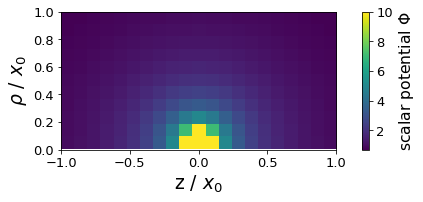

In [12]:
fig, ax = plt.subplots(figsize=(8,3))
img = ax.imshow(phi_mesh, extent=(*z_arr[[0,-1]], *rho_arr[[0,-1]]), aspect='equal', origin='lower')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r"scalar potential $\Phi$", fontsize='large')
ax.set_xlabel("z / $x_{0}$", fontsize='x-large')
ax.set_ylabel(r"$\rho$ / $x_{0}$", fontsize='x-large')
fig.tight_layout()
# fig.savefig("scalar-potential-test-1.png")

In [13]:
tau_arr = np.linspace(0,1,11)
tau_arr - np.sqrt(rho_arr[2]**2 + (z_arr[2] - z_s(0.-tau_arr))**2)

array([-0.82462113, -0.72462113, -0.62462113, -0.52462113, -0.42462113,
       -0.32462113, -0.22462113, -0.12462113, -0.02462113,  0.07537887,
        0.17537887])

In [14]:
retarded_time_eq(tau_arr, 0, rho_arr[2], z_arr[2], z_s)

array([0.82462113, 0.82462113, 0.82462113, 0.82462113, 0.82462113,
       0.82462113, 0.82462113, 0.82462113, 0.82462113, 0.82462113,
       0.82462113])

#### Testing the fixed-point method

In [15]:
from scipy.optimize import fixed_point

In [16]:
from numpy import sqrt
def ftest(x, a):
    return sqrt(x+a)

In [17]:
fixed_point(ftest, 0, args=(2,))

array(2.)